### Setup

In [2]:
!./venv/bin/pip install kaggle scikit-learn numpy matplotlib seaborn

  Using cached kaggle-1.8.3-py3-none-any.whl.metadata (16 kB)
  Using cached scikit_learn-1.8.0-cp313-cp313-macosx_12_0_arm64.whl.metadata (11 kB)
  Using cached numpy-2.4.1-cp313-cp313-macosx_11_0_arm64.whl.metadata (6.6 kB)
  Using cached matplotlib-3.10.8-cp313-cp313-macosx_11_0_arm64.whl.metadata (52 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached bleach-6.3.0-py3-none-any.whl.metadata (31 kB)
  Using cached kagglesdk-0.1.15-py3-none-any.whl.metadata (13 kB)
  Using cached mypy-1.19.1-cp313-cp313-macosx_11_0_arm64.whl.metadata (2.2 kB)
  Using cached python_slugify-8.0.4-py2.py3-none-any.whl.metadata (8.5 kB)
  Using cached requests-2.32.5-py3-none-any.whl.metadata (4.9 kB)
  Using cached types_requests-2.32.4.20260107-py3-none-any.whl.metadata (2.0 kB)
  Using cached types_tqdm-4.67.0.20250809-py3-none-any.whl.metadata (1.7 kB)
  Using cached urllib3-2.6.3-py3-none-any.whl.metadata (6.9 kB)
  Using cached scipy-1.17.0-cp313-cp313-macosx_12_0_arm

In [3]:
!kaggle datasets download -d neuromusic/avocado-prices

Dataset URL: https://www.kaggle.com/datasets/neuromusic/avocado-prices
License(s): ODbL-1.0
100%|████████████████████████████████████████| 629k/629k [00:00<00:00, 1.20MB/s]
100%|████████████████████████████████████████| 629k/629k [00:00<00:00, 1.20MB/s]


In [4]:
!unzip avocado-prices.zip

Archive:  avocado-prices.zip
  inflating: avocado.csv             


### Imports

In [56]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from collections import defaultdict

### Load the Dataset

In [25]:
avo_df = pd.read_csv("./avocado.csv")
avo_df.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [54]:
avo_df.isna().sum()

Unnamed: 0      0
Date            0
AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
year            0
region          0
dtype: int64

### Feature Engineering

Same as in previous homework, so not explaining it again.

In [12]:
clean_df = avo_df.copy()

#### Drop Columns

In [13]:
clean_df = clean_df.drop(clean_df.columns[0], axis=1)

In [14]:
drop_cols = ["region"]

clean_df = clean_df.drop(columns=drop_cols)

#### Convert Categorical

In [15]:
cat_cols = ["type"]

clean_df = pd.get_dummies(clean_df, columns=cat_cols, drop_first=True, dtype=int)

Convert Date

In [16]:
clean_df['Date'] = pd.to_datetime(clean_df['Date'], format='%Y-%m-%d', errors='coerce')
clean_df['Year'] = clean_df['Date'].dt.year
clean_df['Month'] = clean_df['Date'].dt.month
clean_df = clean_df.drop(columns=['Date'])

#### Add Seasons

In [17]:
def get_season(month: int):
    if month <= 2 or month == 12:
        return 0 # Winter
    
    if month >= 3 and month <= 5:
        return 1 # Spring
    
    if month >= 6 and month <= 8:
        return 2 # Summer
    
    if month >= 9 and month <= 11:
        return 3 # Autumn
    

clean_df['Season'] = clean_df['Month'].apply(get_season)

In [18]:
clean_df = pd.get_dummies(clean_df, columns=["Year"], dtype=int)

Two columns with the highest absolute correlation to target column (AveragePrice) are `type_organic` (0.615845) and `Season` (0.224468)

Drop Columns with High Correlation to Each Other

In [19]:
drop_corr_cols = ['4046', '4225', '4770', 'Small Bags', 'Large Bags', 'XLarge Bags', 'year']

clean_df = clean_df.drop(columns=drop_corr_cols)

#### Final Dataset

In [20]:
clean_df.describe()

,AveragePrice,Total Volume,Total Bags,type_organic,Month,Season,Year_2015,Year_2016,Year_2017,Year_2018
count,18249.000000,1.824900e+04,1.824900e+04,18249.000000,18249.000000,18249.000000,18249.000000,18249.000000,18249.000000,18249.000000
mean,1.405978,8.506440e+05,2.396392e+05,0.499918,6.177215,1.414214,0.307688,0.307743,0.313551,0.071018
std,0.402677,3.453545e+06,9.862424e+05,0.500014,3.534130,1.122728,0.461549,0.461572,0.463949,0.256861
min,0.440000,8.456000e+01,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.100000,1.083858e+04,5.088640e+03,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.370000,1.073768e+05,3.974383e+04,0.000000,6.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,1.660000,4.329623e+05,1.107834e+05,1.000000,9.000000,2.000000,1.000000,1.000000,1.000000,0.000000
max,3.250000,6.250565e+07,1.937313e+07,1.000000,12.000000,3.000000,1.000000,1.000000,1.000000,1.000000


### Decision Boundary 

Just as in previous homework, I am choosing `AveragePrice` and `4046` columns for decision boundary.

In [27]:
decision_cols = ['AveragePrice', '4046']

db_df = clean_df[['type_organic']].join(avo_df[decision_cols])

In [31]:
X_db = db_df[decision_cols]
y_db = db_df['type_organic']
X_db

,AveragePrice,4046
0,1.33,1036.74
1,1.35,674.28
2,0.93,794.70
3,1.08,1132.00
4,1.28,941.48
...,...,...
18244,1.63,2046.96
18245,1.71,1191.70
18246,1.87,1191.92
18247,1.93,1527.63


In [32]:
db_scaler = StandardScaler()
X_db = pd.DataFrame(db_scaler.fit_transform(X_db), columns=X_db.columns, index=X_db.index)
X_db.describe()

,AveragePrice,4046
count,1.824900e+04,1.824900e+04
mean,9.967611e-17,-2.491903e-17
std,1.000027e+00,1.000027e+00
min,-2.398960e+00,-2.316356e-01
25%,-7.598823e-01,-2.309604e-01
50%,-8.935061e-02,-2.248011e-01
75%,6.308501e-01,-1.438694e-01
max,4.579537e+00,1.774816e+01


In [33]:
min1, max1 = X_db['AveragePrice'].min()-1, X_db['AveragePrice'].max()+1
min2, max2 = X_db['4046'].min()-1, X_db['4046'].max()+1
# define the x and y scale
x1grid = np.arange(min1, max1, 0.1)
x2grid = np.arange(min2, max2, 0.1)
# create all of the lines and rows of the grid
xx, yy = np.meshgrid(x1grid, x2grid)
# flatten each grid to a vector
r1, r2 = xx.flatten(), yy.flatten()
r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
# horizontal stack vectors to create x1,x2 input for the model
grid = np.hstack((r1,r2))

#### Random Forest vs Decision Tree Decision Boundary

To accurately compare the two decision boundaries, I zoomed in on a part of the graph, where the decision boundary differences are more evident.

Decision tree decision boundary is more robust, with more straight lines. It provides a more general decision boundary, however we can hardly say that the model is underfitting.

Random forest decision boundary captures more granular differences in the data points, even having some "islands", where the decision boundary is isolated from the main boundary. However, just by looking at the graph it is hard to say if the model is overfitting or if it is providing a more non-linear decision boundary.

/Users/maxim/Documents/work/sigmoid_hw/08_Random_Forest/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/maxim/Documents/work/sigmoid_hw/08_Random_Forest/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


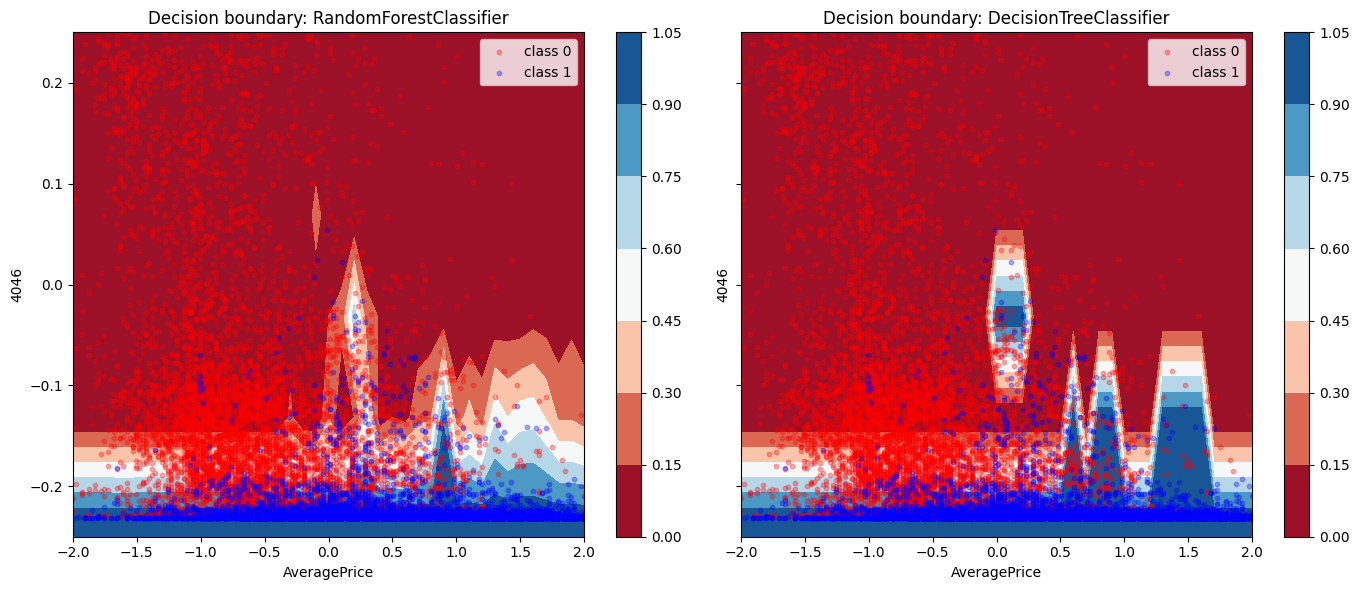

In [46]:
# define and fit the model
models = [RandomForestClassifier(), DecisionTreeClassifier()]

# make two subplots to compare models
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

for ax, model in zip(axes, models):
    # train the model
    model.fit(X_db, y_db)
    
    # predict probabilities on the grid and reshape
    yhat = model.predict_proba(grid)[:, 1]  # prob of class 1 (organic)
    zz = yhat.reshape(xx.shape)
    
    c = ax.contourf(xx, yy, zz, cmap='RdBu')
    for class_value in range(2):
        row_ix = np.where(y_db == class_value)
        ax.scatter(
            X_db['AveragePrice'].iloc[row_ix],
            X_db['4046'].iloc[row_ix],
            alpha=0.3,
            s=10,
            color = 'red' if class_value == 0 else 'blue',
            label=f'class {class_value}'
        )
    ax.set_xlabel("AveragePrice")
    ax.set_ylabel("4046")
    model_name = type(model).__name__
    ax.set_title(f"Decision boundary: {model_name}")
    ax.legend()

    # zooming in 
    plt.axis([-2, 2, -0.25, 0.25])
    plt.colorbar(c, ax=ax)

plt.tight_layout()

### Training

Setting Parameter Grid with necessary parameters

In [47]:
parameters = {
    "max_depth": [4, 8, 16, 32],
    "min_samples_leaf": [1, 2, 4, 8],
    "min_weight_fraction_leaf": [0.0, 0.0001, 0.001],
    "min_samples_split": [4, 8, 16, 32],
    "max_features": [6, 8, 12],
    "max_leaf_nodes": [200, 400, 800, 1200],
    'min_impurity_decrease': [0.0, 0.0001, 0.001]
}

grid = ParameterGrid(parameters)

#### Splitting the Dataset

In [48]:
X = clean_df.drop(columns=['AveragePrice'])
y = clean_df['AveragePrice']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [53]:
X

,Total Volume,Total Bags,type_organic,Month,Season,Year_2015,Year_2016,Year_2017,Year_2018
0,64236.62,8696.87,0,12,0,1,0,0,0
1,54876.98,9505.56,0,12,0,1,0,0,0
2,118220.22,8145.35,0,12,0,1,0,0,0
3,78992.15,5811.16,0,12,0,1,0,0,0
4,51039.60,6183.95,0,11,3,1,0,0,0
...,...,...,...,...,...,...,...,...,...
18244,17074.83,13498.67,1,2,0,0,0,0,1
18245,13888.04,9264.84,1,1,0,0,0,0,1
18246,13766.76,9394.11,1,1,0,0,0,0,1
18247,16205.22,10969.54,1,1,0,0,0,0,1


In [60]:
results = defaultdict(lambda: defaultdict(list))

grid_list = list(grid)
total = len(grid_list)

for idx, params in enumerate(grid_list):
    if idx % 100 == 0:
        print(f"Progress: {idx}/{total} ({100*idx/total:.1f}%)")
    
    model = RandomForestRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    for param_name, param_value in params.items():
        results[param_name][str(param_value)].append({
            'mse': mse, 'mae': mae, 'r2': r2
        })

print("Training complete!")

Progress: 0/6912 (0.0%)
Progress: 100/6912 (1.4%)
Progress: 200/6912 (2.9%)
Progress: 300/6912 (4.3%)
Progress: 400/6912 (5.8%)
Progress: 500/6912 (7.2%)
Progress: 600/6912 (8.7%)
Progress: 700/6912 (10.1%)
Progress: 800/6912 (11.6%)
Progress: 900/6912 (13.0%)
Progress: 1000/6912 (14.5%)
Progress: 1100/6912 (15.9%)
Progress: 1200/6912 (17.4%)
Progress: 1300/6912 (18.8%)
Progress: 1400/6912 (20.3%)
Progress: 1500/6912 (21.7%)
Progress: 1600/6912 (23.1%)
Progress: 1700/6912 (24.6%)
Progress: 1800/6912 (26.0%)
Progress: 1900/6912 (27.5%)
Progress: 2000/6912 (28.9%)
Progress: 2100/6912 (30.4%)
Progress: 2200/6912 (31.8%)
Progress: 2300/6912 (33.3%)
Progress: 2400/6912 (34.7%)
Progress: 2500/6912 (36.2%)
Progress: 2600/6912 (37.6%)
Progress: 2700/6912 (39.1%)
Progress: 2800/6912 (40.5%)
Progress: 2900/6912 (42.0%)
Progress: 3000/6912 (43.4%)
Progress: 3100/6912 (44.8%)
Progress: 3200/6912 (46.3%)
Progress: 3300/6912 (47.7%)
Progress: 3400/6912 (49.2%)
Progress: 3500/6912 (50.6%)
Progress: 3

#### Calculate Avg Performance

In [61]:
avg_results = {}
for param_name, values_dict in results.items():
    avg_results[param_name] = {}
    for value, metrics_list in values_dict.items():
        avg_results[param_name][value] = {
            'avg_mse': np.mean([m['mse'] for m in metrics_list]),
            'avg_mae': np.mean([m['mae'] for m in metrics_list]),
            'avg_r2': np.mean([m['r2'] for m in metrics_list]),
            'count': len(metrics_list)
        }

#### Visualize Hyperparameter vs Performance Relation

In [62]:
def draw_perf_plot(axis, values, labels, label, color):
    axis.plot(range(len(values)), values, marker='o', linewidth=2, color=color)
    axis.set_xticks(range(len(values)))
    axis.set_xticklabels(labels)
    axis.set_ylabel(label)
    axis.set_title(f'{param_name} vs {label}')
    axis.grid(True, alpha=0.3)

- `max_depth` increase the tree depth, deeper => more decisions can be taken => more accurate results, but prone to overfitting

- `min_samples_split` is the minimum number of samples required to split an internal node. Small number tends to overfit, large number prevents learning
- `min_samples_leaf` guarantees a minimal number of leafs, avoiding low-variance, overfit leaf nodes
- `min_weight_fraction_leaf` ensures that leaf nodes contain at least a fraction of the overall sum of the sample weights
- `max_features` controls how many features a node can analyze, same behaviour as with max_depth
- `max_leaf_nodes` sets how many leaf nodes the tree has, too few or too many can be noisy when averaging the final result
- `min_impurity_decrease` controls how much mean decrease in impurity (MDI) we expect from the training process

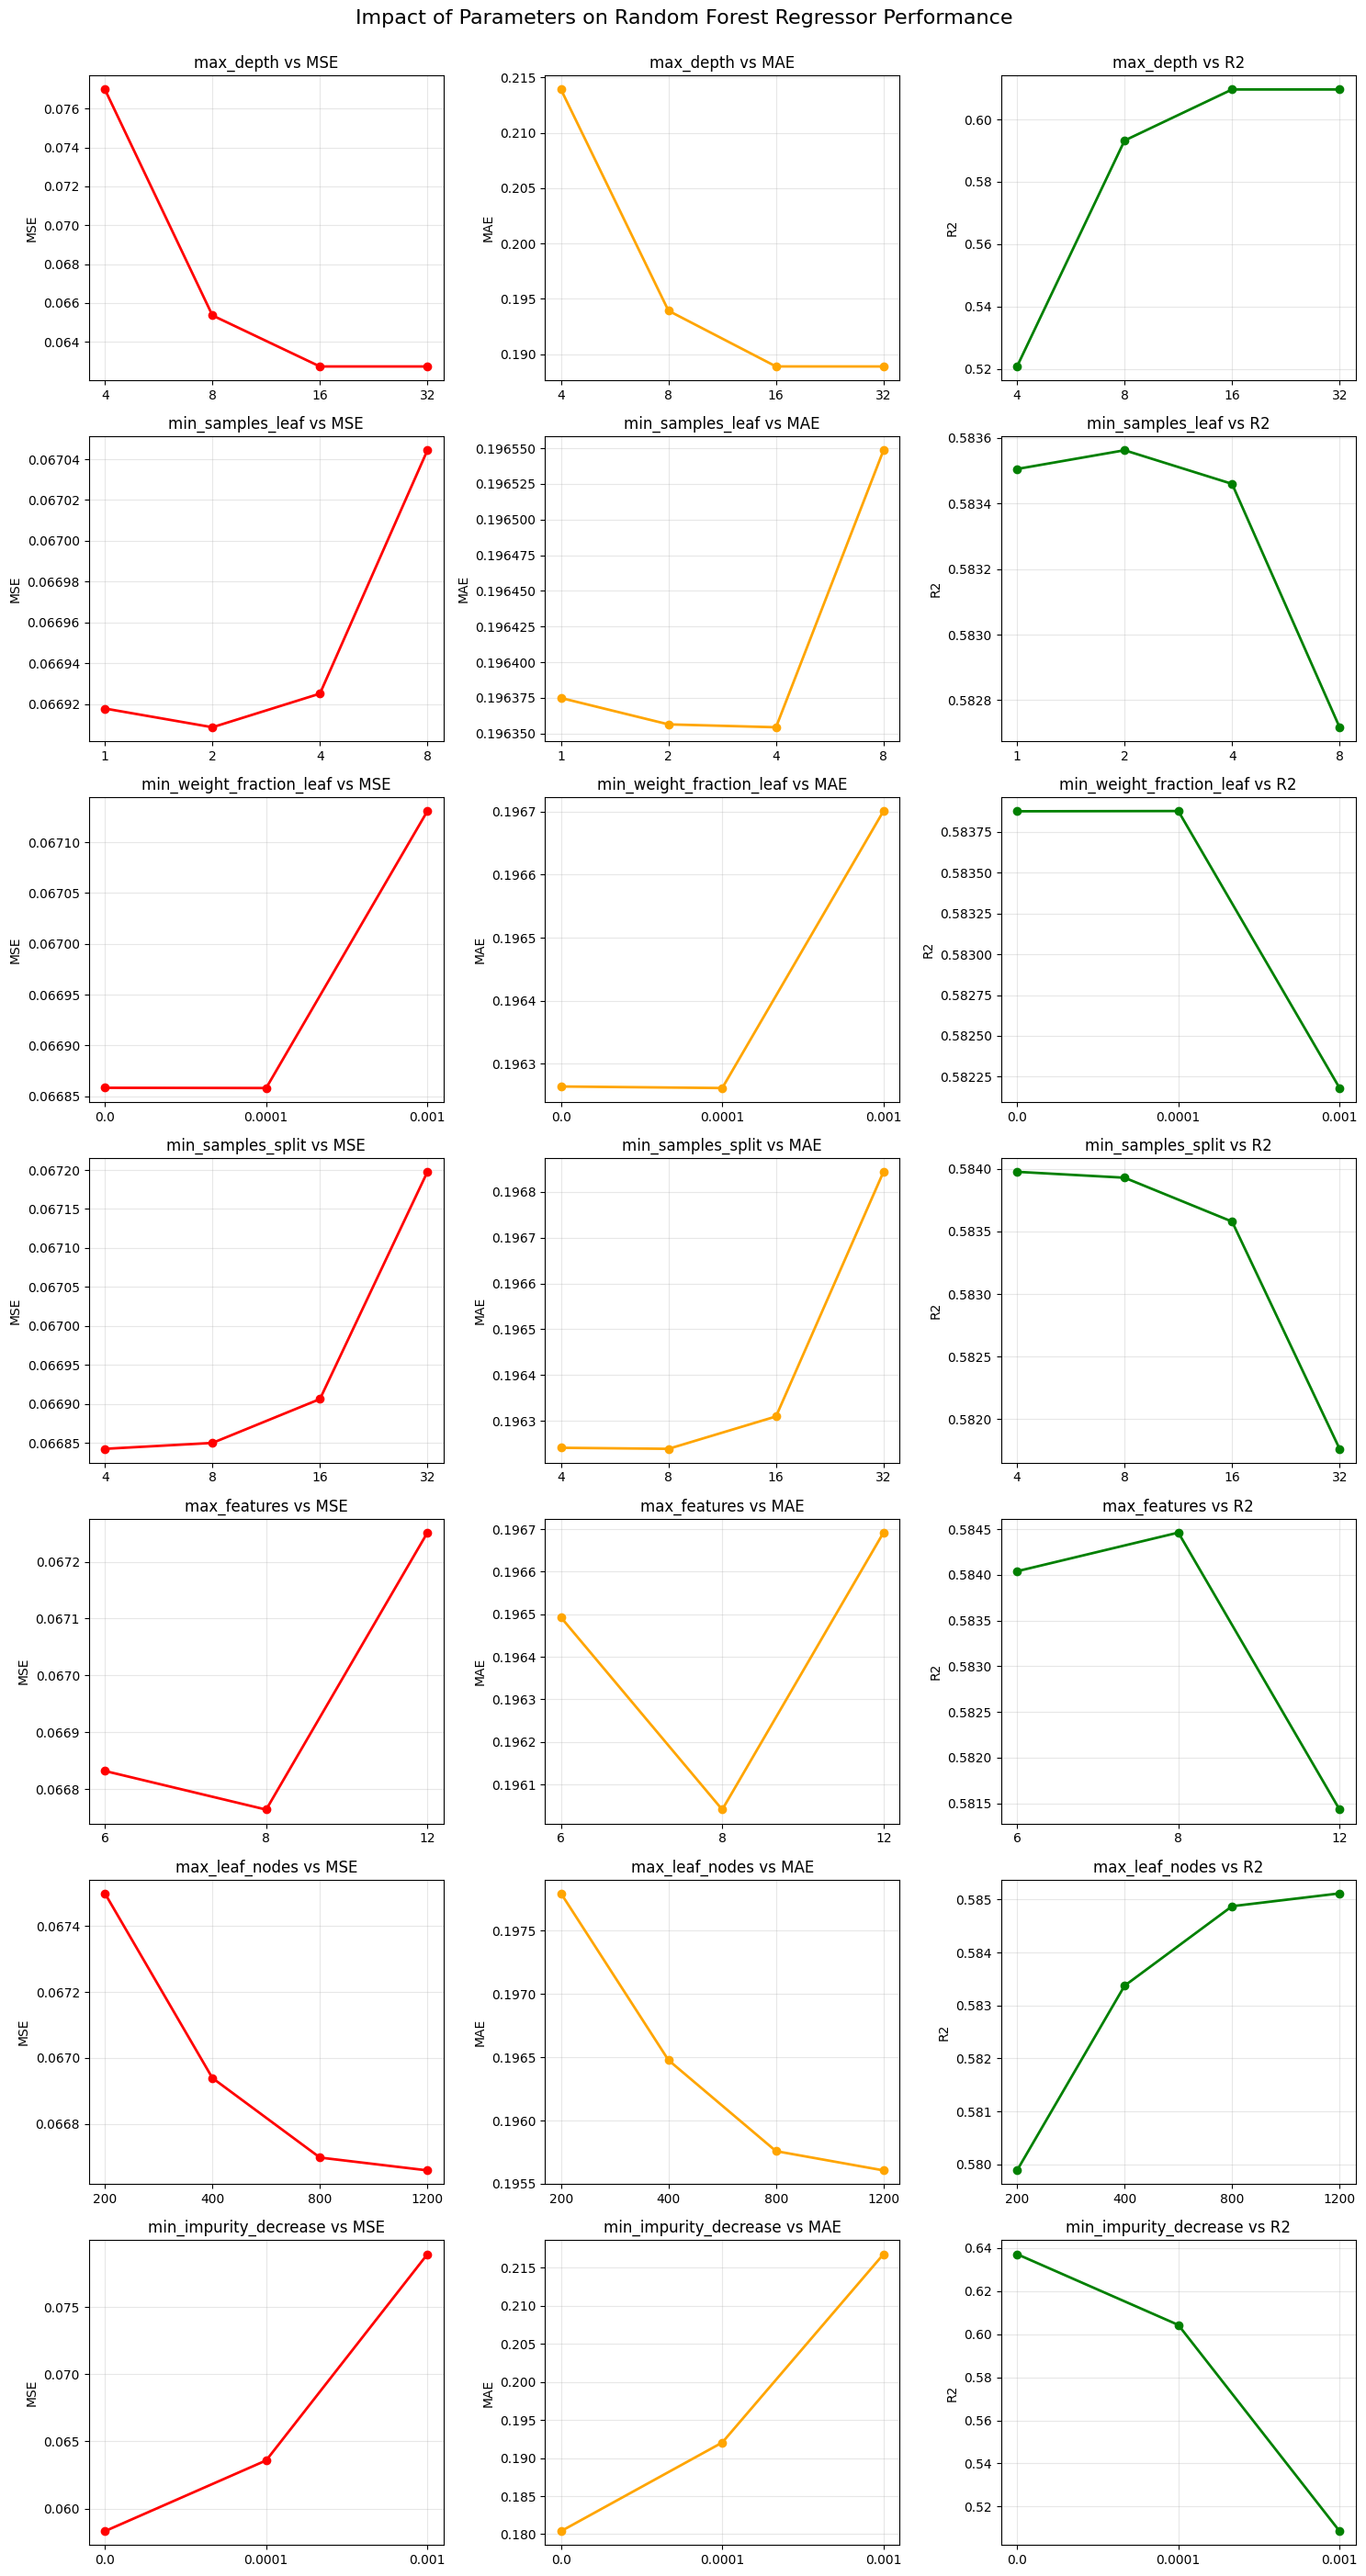

In [63]:
fig, axes = plt.subplots(len(parameters), 3, figsize=(15, 4*len(parameters)))
fig.suptitle('Impact of Parameters on Random Forest Regressor Performance', fontsize=16, y=1.0)

for idx, param_name in enumerate(parameters.keys()):
    values = sorted(avg_results[param_name].keys(), key=lambda x: (x == 'None', float(x) if x != 'None' else float('inf')))
    
    mse_vals = [avg_results[param_name][v]['avg_mse'] for v in values]
    mae_vals = [avg_results[param_name][v]['avg_mae'] for v in values]
    r2_vals = [avg_results[param_name][v]['avg_r2'] for v in values]

    draw_perf_plot(axes[idx, 0], mse_vals, values, 'MSE', 'red')
    draw_perf_plot(axes[idx, 1], mae_vals, values, 'MAE', 'orange')
    draw_perf_plot(axes[idx, 2], r2_vals, values, 'R2', 'green')

plt.tight_layout()


#### Train Best Model

Since with random forests we may not normalize the data, we can directly compare the errors with the target variable.

From previous analysis, `AveragePrice` std is `0.402677`, meanwhile our MAE is `0.1560`, so our model is not just guessing the value in a meaningful interval. R2 score of about 0.7 indicates that our independent variables are predicting about 70% of the variance of the dependent variable. Finally, out-of-bag error for regressor models is just an inverse of R2 score. OOB score is usually calculated for random forest classificators.

RandomForestRegressor achieved a better performance than DecisionTreeRegressor. Reminder of the metrics of DecisionTreeRegressor:

MSE: 0.0578

MAE: 0.1762

R2: 0.6400

Since the decision boundary of a random forest can be more complex than that of a decision tree, random forest can capture finer patterns in the dataset, and, hence, produces a better prediction across all metrics. However, the training time of the random forest on the parameter grid was much slower due to their increased complexity. There is certainly a trade-off between the training time and accuracy for these two models.

In [94]:
best_params = {}
    
for param_name, values_dict in avg_results.items():
    best_value = None
    best_r2 = -float('inf')
    best_metrics = None
    
    for value, metrics in values_dict.items():
        if metrics['avg_r2'] > best_r2:
            best_r2 = metrics['avg_r2']
            best_value = value
            best_metrics = metrics
    
    best_params[param_name] = float(best_value) if '.' in best_value else int(best_value)


print("Best Parameters:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

best_model = RandomForestRegressor(**best_params, oob_score=True, random_state=42)
best_model.fit(X_train, y_train)
best_y_pred = best_model.predict(X_test)

print(f"\nBest MSE: {mean_squared_error(y_test, best_y_pred):.4f}")
print(f"\nBest MAE: {mean_absolute_error(y_test, best_y_pred):.4f}")
print(f"\nBest R2: {r2_score(y_test, best_y_pred):.4f}")
print(f"\nBest OOB error: {(1 - best_model.oob_score_):.4f}")

Best Parameters:
  max_depth: 16
  max_features: 8
  max_leaf_nodes: 1200
  min_impurity_decrease: 0.0
  min_samples_leaf: 2
  min_samples_split: 4
  min_weight_fraction_leaf: 0.0001

Best MSE: 0.0465

Best MAE: 0.1560

Best R2: 0.7107

Best OOB error: 0.2908


### Feature Importance

When performing EDA, we have calculate the correlation of each feature to the target variable (done in prev homework). Now, we can see the actual importance of feature towards predicting the target variable.

In [68]:
feature_imp=pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
feature_imp

type_organic    0.403115
Total Volume    0.201790
Total Bags      0.190548
Season          0.063328
Month           0.057029
Year_2017       0.053928
Year_2016       0.015271
Year_2015       0.011957
Year_2018       0.003034
dtype: float64

#### Compare with correlation

We can see that the correlation values are usually higher than the feature importance of the random forest model. It can attributed to the fact that the model has not fully learned the importance of each variable. We can conclude that correlation is a theoretical metric, the "maximum" that the model can get out of a feature, while feature importance is the practical value that we got from the model.

In [91]:
corr = X.join(y).corr().abs()
corr = corr.drop(["AveragePrice"], axis=0)
corr["AveragePrice"]

pd.concat([
    feature_imp.rename("feature_importance"), 
    corr["AveragePrice"].rename("correlation")
], axis=1)

,feature_importance,correlation
type_organic,0.403115,0.615845
Total Volume,0.201790,0.192752
Total Bags,0.190548,0.177088
Season,0.063328,0.224468
Month,0.057029,0.162409
Year_2017,0.053928,0.183200
Year_2016,0.015271,0.111502
Year_2015,0.011957,0.050311
Year_2018,0.003034,0.040133


#### Visualizing Feature Importance

Below is a quick bar chart with feature importances. They are proportional to the correlation analysis, however they values of each year have a much smaller importance than in the preliminary analysis.

/var/folders/0x/qk2w9_r113j9nkv7jp_g4pv00000gn/T/ipykernel_12953/1669461264.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


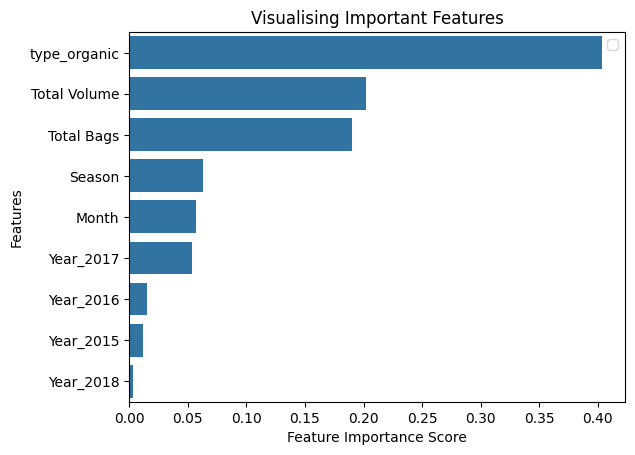

In [67]:
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel("Feature Importance Score")
plt.ylabel("Features")
plt.title("Visualising Important Features")
plt.legend()
plt.show()